In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
import scipy as sp

from mpl_toolkits import mplot3d




from scipy.special import softmax
#np.set_printoptions(precision=1)
%matplotlib notebook
#plt.close('all')

In [2]:
def make_nodefeature(x,y,r,t):
    A=np.zeros((len(x),2))
       
    
    



def make_adjacency(x,y,r,t,ide,split_id,run):
    A=np.zeros((len(x),len(x)))
    x_id = []
    t_id = []
    for i in range(len(x)):
        x_id.append(i+1)
        t_id.append(t[i])
        for j in range(len(x)):
            if ide[i]==ide[j] and ide[i]!=-2:
                if t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
            elif ide[i]==split_id[j]:
                if ide[i]==-1:
                    A[i,j]=1
                elif t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
              
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'timetable.txt',np.c_[x_id,t_id], fmt='%i',delimiter='\t')
    
    return A
        

    
def make_weighted_adj_estimate(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            A[i,0]=1.5
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=gaus2d(x[j], y[j], x[i], y[i]) #1/((x[i]-x[j])**2+(y[i]-y[j])**2)
            #if i>j:
                #A[i,j]=0
        if np.sum(A[i,:])!=0:
            A[i,:]=mean_normal(A[i,:])
        #print(A[i,:],i)
       
    A=A.round(decimals=2)
    
    np.savetxt('./'+str(run)+'/'+'B.txt', A)
    return A
    
    
def make_dist_matrix(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
       
    
    
    np.savetxt('./'+str(run)+'/'+'D.txt', A)
    return A


def make_weighted_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j and j!=0:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                w.append(A[i,j]*100)
    
    
    np.savetxt('./node2vec/graph/'+str(run)+'.edgelist', np.c_[e1,e2,w], fmt='%i',delimiter='\t')
    return A,e1,e2,w



def make_true_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                #w.append(A[i,j])
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0


def mean_normal(x):
    s=np.sum(x)
    return x/s


def gaus2d(x, y, mx, my, sx=0.07, sy=0.07):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))



def padding(maxlen,run):
    #A,B,E
    
    B=np.loadtxt('./'+str(run)+'/'+'B.txt')
    A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
    E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
                B[i,j]=0
                
    np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    #A=np.zeros((4,4))
    #B=np.zeros((4,4))
    
   #E=np.ones((4,6))
    
    h=np.ones(maxlen)*-1
    v=np.ones(len(A[0]))*-1
    
    #
    cur_E=len(E)
    cur_A=len(A)
    cur_Ah=len(A[0])
    zero_line=np.zeros(len(E[0]))
    for i in range(maxlen-cur_E):
        E=np.vstack([E, zero_line])
        
    for j in range(maxlen-cur_A):
        A=np.vstack([A, v])
        B=np.vstack([B, v])
        
    for z in range(maxlen-cur_Ah):
        A=np.column_stack([A, h])
        B=np.column_stack([B, h])
        
    #np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'B_padded.txt', B)
    np.savetxt('./'+str(run)+'/'+'embed_padded.txt',E)
    print(A.shape)   
    return A,B,E    
    
#x = np.linspace(-5, 5)
#y = np.linspace(-5, 5)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
#z = gaus2d(x, y)

#def correct(A,B,E,max_len,run):



#def A_B_dense(A,B):
    
    

In [3]:
A=np.loadtxt('./'+str(2)+'/'+'embed.txt')
#print(A)

A=np.vstack([A, np.zeros(len(A[0]))])
#A=np.append(A,np.zeros(len(A[0])))
#print(A)

print(gaus2d(1.8*0.07, 1.8*0.07, 0, 0, sx=0.07, sy=0.07))


A,B,E =padding(7,1)

print(E)

1.2720668358645384
(248, 248)
[[-0.3687159   0.06144139 -0.3133386  ... -0.05873963  0.00668316
  -0.10852037]
 [-0.74604446 -0.03913222 -0.5305872  ... -0.10701833  0.34105924
  -0.04511976]
 [-0.65130514 -0.09012141 -0.10186411 ...  0.13368706  0.09981185
  -0.25241277]
 ...
 [ 0.04298845  0.3812869  -0.2508644  ...  0.05237618  0.17417026
  -0.03347298]
 [-0.38734066  0.04964852 -0.26751944 ... -0.08899054  0.11219852
  -0.08002541]
 [-0.43283558 -0.02140075 -0.22880073 ... -0.2504424   0.01860724
   0.08467789]]


In [4]:
lenA=[]
for i in range(1,15):

    run=i

    x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)
    #print(len(x))
    A=make_adjacency(x,y,r,t,ide,split_id,run)
    print(len(A),i)
    lenA.append(len(A))
    
    B=make_weighted_adj_estimate(x,y,t,run)
    #print(B)
    C,e1,e2,w=make_weighted_edgelist(B,run)
    make_true_edgelist(A,run)
    
    make_dist_matrix(x,y,t,run)
    
maxlen=np.max(lenA)
print(maxlen)






248 1
234 2
254 3
223 4
219 5
195 6
211 7
239 8
238 9
240 10
292 11
215 12
285 13
227 14
292


In [5]:
#print(stop)

for i in range(1,15):

    run=i

    b = np.loadtxt('./node2vec/emb/'+str(run)+'.emb',skiprows=1, delimiter=' ', unpack=True)

    ind=np.argsort(b[0])

    for l in range(len(b)):
        b[l]= np.take_along_axis(b[l], ind,axis=0)  
    b=np.transpose(b)
    b=b[:,1:]
    
    #pos= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #split_prob = pos.T[:,5]
    #split_prob = split_prob[:, np.newaxis]
    #r = pos.T[:,2]
    #r=r[:, np.newaxis]
    
    #print(b.shape,pos.shape)
    
    #b=np.append(b,r,axis=1)
    #b=np.append(b,split_prob,axis=1)
    
    #np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    
    
    ##remove below if n2v is used
    
    print(len(b[0]))
    
    #p = np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #split_prob = p.T[:,5]
    #print(len(split_prob),split_prob)
    #b = b.T[:,0:3]
    #split_prob=split_prob[:, np.newaxis]
    #print(len(b),b)
    
    #print(b.shape,split_prob.shape)
    
    #######b=np.append(b,split_prob,axis=1)
    
    #b=np.append(pos,split_prob,axis=1)
    
    
    #print(b)
    #b=np.repeat(b, 6, axis=1)
    #print(i)
    #print(b)
    
    np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    padding(maxlen,run)
    

48
(292, 292)
48
(292, 292)
48
(292, 292)
48
(292, 292)
48
(292, 292)
48
(292, 292)
48
(292, 292)
48
(292, 292)
48
(292, 292)
48
(292, 292)
48
(292, 292)
48
(292, 292)
48
(292, 292)
48
(292, 292)


python ./src/main.py --input ./graph/14.edgelist --output ./emb/14.emb --dimensions 25 --walk-length 40 --num-walks 300 --window-size 30 --p 0.25 --q 4 --iter 20 --weighted

[ 1.01919820e-01 -2.12063580e-01  4.48203830e-02  4.91051700e-02
  1.05615990e-01  3.74645700e-02  5.31286900e-02 -1.34288310e-01
 -9.15619360e-02  6.16359670e-02  2.11575120e-01  2.43110140e-01
  2.70332500e-01 -1.99931830e-01  3.46025900e-01 -3.87937720e-01
  9.86079800e-02  2.59202900e-01  1.69092660e-01 -4.91806500e-01
  4.70639680e-01  1.30484860e-01 -6.33294640e-01  9.49814700e-02
  6.25925500e-01 -7.10714460e-01  6.80657800e-01  1.21512900e-01
  1.74694640e-02 -5.46543660e-01  6.53466400e-01  5.64179060e-01
 -6.68325200e-02 -3.24557700e-01 -4.43453430e-01  4.98858300e-01
 -3.56788840e-01 -3.55610030e-02 -5.17602000e-02  5.42896280e-02
  3.32626040e-01  1.17284470e-01  1.77148860e-01 -2.71225000e-01
 -1.28310810e-01  2.12035900e-01 -1.46543260e-02  1.68424590e-01
  2.77280700e-01  3.24213150e-01  1.21361260e-01  2.11704500e-01
  3.18078200e-01  4.14669250e-01  1.10535250e-01  3.97290380e-01
  2.34148850e-01  6.08019800e-02  4.16266260e-01  2.37720940e-01
  1.70148280e-01  1.30873

<IPython.core.display.Javascript object>


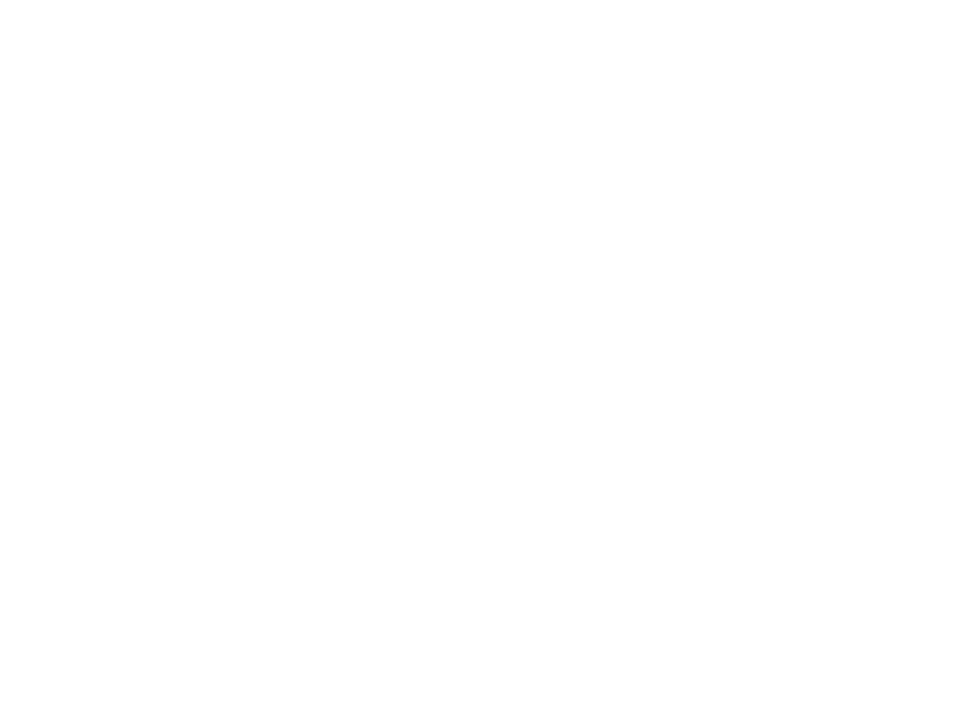

In [6]:

#np.savetxt('./node2vec/emb/'+str(10)+'.emb',i)
x,y= np.loadtxt('./'+str(2)+'/'+'embed.txt',usecols=(0,1),unpack=True)
print(x,y)
#i=ide
#print(i)
#print(i[0])
plt.scatter(x,y,s=1)
#plt.scatter(x[1],y[1],c='r')
#plt.scatter(x[i==4],y[i==4],c='blue')
#plt.scatter(x[i==5],y[i==5],c='g')
#plt.scatter(x[i==6],y[i==6],c='black')
#plt.scatter(x[i==7],y[i==7],c='violet')
#plt.scatter(x[i==10],y[i==10],c='orange')
#plt.scatter(x[i==2],y[i==2],c='grey')

In [7]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

run=7

x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)



#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
id1,id2,w=np.loadtxt('./node2vec/graph/'+str(run)+'.edgelist', delimiter='\t', usecols=(0,1,2), unpack=True)
xline=[]
yline=[]
tline=[]
for i in range(len(id1)):
    
    xline=[]
    yline=[]
    tline=[]
    
    print(id1[i],id2[i])
    xline.append(x[int(id1[i]-1)])   
    yline.append(y[int(id1[i]-1)])
    tline.append(t[int(id1[i]-1)])
    
    xline.append(x[int(id2[i]-1)])
    yline.append(y[int(id2[i]-1)])
    tline.append(t[int(id2[i]-1)])
    
    print(xline)
    
    ax.plot3D(tline, yline, xline, c='red',alpha=w[i]/100)
    #ax.plot3D(tline, yline, xline, c='grey')


#zline = np.linspace(0, 15, 1000)
#xline = np.sin(zline)
#yline = np.cos(zline)
#

# Data for three-dimensional scattered points
zdata = x
xdata = t
ydata = y
ax.scatter3D(xdata, ydata, zdata);

<IPython.core.display.Javascript object>

1.0 1.0
[2.0, 2.0]
2.0 1.0
[0.17444889779559117, 2.0]
2.0 5.0
[0.17444889779559117, 0.07281058800684202]
2.0 7.0
[0.17444889779559117, 0.24429600495945514]
3.0 1.0
[0.11853707414829659, 2.0]
3.0 6.0
[0.11853707414829659, 0.14019887253385138]
4.0 1.0
[0.12034068136272545, 2.0]
4.0 5.0
[0.12034068136272545, 0.07281058800684202]
4.0 7.0
[0.12034068136272545, 0.24429600495945514]
5.0 1.0
[0.07281058800684202, 2.0]
5.0 10.0
[0.07281058800684202, 0.2320487083209663]
5.0 12.0
[0.07281058800684202, 0.04486490805509699]
6.0 1.0
[0.14019887253385138, 2.0]
6.0 11.0
[0.14019887253385138, 0.16484838374479777]
7.0 1.0
[0.24429600495945514, 2.0]
7.0 10.0
[0.24429600495945514, 0.2320487083209663]
8.0 1.0
[0.9559118236472945, 2.0]
9.0 1.0
[0.48296593186372744, 2.0]
9.0 14.0
[0.48296593186372744, 0.20768895300064003]
10.0 1.0
[0.2320487083209663, 2.0]
10.0 16.0
[0.2320487083209663, 0.10349614304514315]
10.0 17.0
[0.2320487083209663, 0.23151989450669522]
11.0 1.0
[0.16484838374479777, 2.0]
11.0 13.0
[0.1

68.0 76.0
[0.015231511971365484, 0.13036198479028716]
68.0 77.0
[0.015231511971365484, 0.042679570175057295]
68.0 81.0
[0.015231511971365484, 0.04679234749918801]
69.0 1.0
[0.04432740170710346, 2.0]
69.0 74.0
[0.04432740170710346, 0.0024020235993771344]
69.0 80.0
[0.04432740170710346, 0.18363773046081275]
70.0 1.0
[0.124717053532999, 2.0]
70.0 75.0
[0.124717053532999, 0.186535576680827]
70.0 76.0
[0.124717053532999, 0.13036198479028716]
70.0 77.0
[0.124717053532999, 0.042679570175057295]
70.0 81.0
[0.124717053532999, 0.04679234749918801]
71.0 1.0
[0.19056125711814384, 2.0]
71.0 74.0
[0.19056125711814384, 0.0024020235993771344]
71.0 80.0
[0.19056125711814384, 0.18363773046081275]
72.0 1.0
[0.033899372467225214, 2.0]
72.0 75.0
[0.033899372467225214, 0.186535576680827]
72.0 76.0
[0.033899372467225214, 0.13036198479028716]
72.0 77.0
[0.033899372467225214, 0.042679570175057295]
72.0 81.0
[0.033899372467225214, 0.04679234749918801]
73.0 1.0
[0.1324361336744048, 2.0]
73.0 75.0
[0.132436133674

113.0 119.0
[0.15241497607901439, 0.013500392638592004]
113.0 122.0
[0.15241497607901439, 0.16258751588918724]
113.0 124.0
[0.15241497607901439, 0.1810164280681712]
113.0 125.0
[0.15241497607901439, 0.022940386989497033]
114.0 1.0
[-7.487608722454159e-05, 2.0]
114.0 119.0
[-7.487608722454159e-05, 0.013500392638592004]
114.0 121.0
[-7.487608722454159e-05, 0.17172737914421757]
114.0 122.0
[-7.487608722454159e-05, 0.16258751588918724]
114.0 124.0
[-7.487608722454159e-05, 0.1810164280681712]
114.0 125.0
[-7.487608722454159e-05, 0.022940386989497033]
115.0 1.0
[0.05482724860938272, 2.0]
115.0 119.0
[0.05482724860938272, 0.013500392638592004]
115.0 122.0
[0.05482724860938272, 0.16258751588918724]
115.0 124.0
[0.05482724860938272, 0.1810164280681712]
115.0 125.0
[0.05482724860938272, 0.022940386989497033]
116.0 1.0
[0.11823806433115182, 2.0]
116.0 120.0
[0.11823806433115182, 0.07924810035162029]
116.0 123.0
[0.11823806433115182, 0.035563946195273574]
117.0 1.0
[0.06355270991228522, 2.0]
117.0

148.0 159.0
[0.0205918762455931, 0.08193180704086887]
149.0 1.0
[0.12625250501002003, 2.0]
149.0 153.0
[0.12625250501002003, 0.05446462320469829]
149.0 155.0
[0.12625250501002003, 0.034203510407724895]
149.0 156.0
[0.12625250501002003, -0.052975247350484436]
149.0 158.0
[0.12625250501002003, 0.17355196550845112]
149.0 160.0
[0.12625250501002003, 0.2703970020082791]
150.0 1.0
[0.09997176869353391, 2.0]
150.0 167.0
[0.09997176869353391, 0.03458410983852634]
150.0 172.0
[0.09997176869353391, 0.1260133478841327]
151.0 1.0
[0.10889572443363421, 2.0]
151.0 162.0
[0.10889572443363421, 0.11326261372353448]
151.0 167.0
[0.10889572443363421, 0.03458410983852634]
151.0 172.0
[0.10889572443363421, 0.1260133478841327]
152.0 1.0
[-0.02925490883542051, 2.0]
152.0 161.0
[-0.02925490883542051, 0.0006054565639627835]
152.0 165.0
[-0.02925490883542051, 0.13173693843680215]
152.0 166.0
[-0.02925490883542051, 0.18015394886229877]
152.0 168.0
[-0.02925490883542051, 0.03283184343916692]
152.0 170.0
[-0.02925

178.0 187.0
[0.025308708947285378, 0.0017578527959468265]
178.0 190.0
[0.025308708947285378, 0.09520850129104064]
178.0 192.0
[0.025308708947285378, 0.15840414390877539]
178.0 193.0
[0.025308708947285378, 0.22721210450164606]
179.0 1.0
[0.16032064128256512, 2.0]
179.0 194.0
[0.16032064128256512, 0.07281381512177759]
179.0 195.0
[0.16032064128256512, 0.12488287919265989]
179.0 196.0
[0.16032064128256512, 0.04102661275390535]
180.0 1.0
[0.19189453666620387, 2.0]
180.0 187.0
[0.19189453666620387, 0.0017578527959468265]
180.0 188.0
[0.19189453666620387, 0.2518772488480441]
180.0 189.0
[0.19189453666620387, 0.3600503571741476]
180.0 190.0
[0.19189453666620387, 0.09520850129104064]
180.0 192.0
[0.19189453666620387, 0.15840414390877539]
180.0 193.0
[0.19189453666620387, 0.22721210450164606]
180.0 198.0
[0.19189453666620387, 0.09094243650701758]
181.0 1.0
[0.1516194823428148, 2.0]
181.0 186.0
[0.1516194823428148, 0.020931622302955682]
181.0 187.0
[0.1516194823428148, 0.0017578527959468265]
181

In [8]:
def colour_func(ii,prev_c,prev_id,id1,id2):
    id1=id1[id2==ii]
    #print(id1,id2)
    if len(id1)==0:
        return prev_c[int(ii-1)]
    else:
        #print(id1,prev_id,prev_c)
        print('prev_c',np.array(prev_c))
        c_cf=np.array(prev_c)[prev_id==id1[0]]
        print('c',c_cf)
    return c_cf[0]
    


c=['blue','green','violet']

id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
id_f=[1,2,3]


print(c[id_f==1])


    


for t in range(31):
    
    
    my_dpi=96
    pix=150
    
    
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    fig = plt.gcf()
    ax = fig.gca()
    
    print('c_full',c)
    prev_c=c
    prev_id=id_f
    
    c=[]
    id_f=[]
    
    for u in range(len(id[tt==t])):
        x_n=x[int(id[tt==t][u]-1)]  
        y_n=y[int(id[tt==t][u]-1)]
        r_n=r[int(id[tt==t][u]-1)]  
        c_cf=colour_func(id[tt==t][u],prev_c,prev_id,id1,id2)
        c.append(c_cf)
        #print('c.app',c)
        id_f.append(id[tt==t][u])
        circ1=plt.Circle((x_n,y_n), r_n, color=c_cf)
        ax.add_patch(circ1)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.savefig('./'+str(run)+'_GT'+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 

blue


<IPython.core.display.Javascript object>

c_full ['blue', 'green', 'violet']
prev_c ['blue' 'green' 'violet']
c ['blue']


IndexError: list index out of range

In [ ]:
x_t=[]
for j in range(len(ide)):
    x_t=[]
    x_t.append(x[ide==j])
    print(str(j),x_t)